In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from utils import evaluate, evaluate_ensemble

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

# tensorflow RNG
# tf.random.set_seed(seed)

In [3]:
data_path = Path("/mnt/nas/backups/08-07-2020/desktopg01/lisa/Data/CSV")

In [4]:
model_path=Path("./models")

In [5]:
train_csv = pd.read_csv(data_path/"train_small.csv", usecols=['document_type', 'body'])
val_csv = pd.read_csv(data_path/"validation_small.csv", usecols=['document_type', 'body'])
test_csv = pd.read_csv(data_path/"test_small.csv", usecols=['document_type', 'body'])

In [6]:
train_csv["is_valid"] = False
val_csv["is_valid"] = True
data = pd.concat([train_csv, val_csv])

In [ ]:
# dls_lm = TextDataLoaders.from_df(data, seed=seed, is_lm=True, text_col="body",
#                                  valid_col="is_valid", tok_tfm=Tokenizer.from_df('body', tok=tok))

In [ ]:
dls_lm = DataBlock(
    blocks=(TextBlock.from_df('body', tok=SentencePieceTokenizer(), is_lm=True)),
    get_x=ColReader('text'), splitter=ColSplitter()).dataloaders(data)

In [ ]:
dls_lm.vocab[:15], len(dls_lm.vocab)

In [ ]:
assert len(train_csv) == len(dls_lm.train_ds) and len(val_csv) ==len(dls_lm.valid_ds)

In [ ]:
torch.save(dls_lm, "./data/dls_lm.pth")

In [18]:
dls_lm = torch.load("./data/dls_lm.pth")

In [22]:
dls_lm.show_batch()

,text,text_
0,"▁xxbos ▁{"" recebem os ▁duso ▁comerci o ▁produtos ▁para ▁informatic a ▁ltda ▁produtos ▁contante s ▁nota ▁fiscal ▁indicada ▁lado ▁e ▁número ▁data ▁recebimento ▁identificação ▁assinatura ▁recebedor ▁série ▁identificação ▁emitente ▁duso ▁comerci o ▁produtos ▁para ▁informatic a ▁da nfe ▁avenida ▁primeiro ▁maio ▁documento ▁auxiliar ▁nota ▁fiscal ▁eletrônica ▁vila ▁virgini a ▁ribeira o ▁preto ▁chave ▁acesso ▁nf ▁cep ▁saída ▁fone ▁número ▁série ▁consulta ▁autenticidade ▁portal ▁nacional ▁nf ▁folha ▁xxup ▁site ▁no ▁site ▁sefaz ▁autorizada","▁{"" recebem os ▁duso ▁comerci o ▁produtos ▁para ▁informatic a ▁ltda ▁produtos ▁contante s ▁nota ▁fiscal ▁indicada ▁lado ▁e ▁número ▁data ▁recebimento ▁identificação ▁assinatura ▁recebedor ▁série ▁identificação ▁emitente ▁duso ▁comerci o ▁produtos ▁para ▁informatic a ▁da nfe ▁avenida ▁primeiro ▁maio ▁documento ▁auxiliar ▁nota ▁fiscal ▁eletrônica ▁vila ▁virgini a ▁ribeira o ▁preto ▁chave ▁acesso ▁nf ▁cep ▁saída ▁fone ▁número ▁série ▁consulta ▁autenticidade ▁portal ▁nacional ▁nf ▁folha ▁xxup ▁site ▁no ▁site ▁sefaz ▁autorizada ▁natureza"
1,"▁constituição ▁está ▁expressamente ▁fundado ▁princípio ▁solidariedade ▁xxup ▁artigo _40 ▁cf ▁por ▁força ▁qual ▁financiamento ▁previdência ▁não ▁tem ▁como ▁contrapartida ▁necessária ▁previsão ▁prestações ▁específicas ▁proporcionais ▁favor ▁contribuinte ▁manifestação ▁mais ▁evidente ▁desse ▁princípio ▁a ▁sujeição ▁contribuição ▁dos ▁próprios ▁inativos ▁pensionistas ▁rua ▁santos ▁d umont ▁pelotas ▁cep ▁fone ▁mail ▁xxup ▁email ""} ▁xxbos ▁{"" social ▁n ▁s ▁previd ▁fábi o ▁munhoz ▁fim ▁djf ▁região ▁ disponibilização ▁quinta ▁feira ▁de ▁fevereiro ▁arquivo ▁publicação ▁juizados ▁especiais ▁federais","▁está ▁expressamente ▁fundado ▁princípio ▁solidariedade ▁xxup ▁artigo _40 ▁cf ▁por ▁força ▁qual ▁financiamento ▁previdência ▁não ▁tem ▁como ▁contrapartida ▁necessária ▁previsão ▁prestações ▁específicas ▁proporcionais ▁favor ▁contribuinte ▁manifestação ▁mais ▁evidente ▁desse ▁princípio ▁a ▁sujeição ▁contribuição ▁dos ▁próprios ▁inativos ▁pensionistas ▁rua ▁santos ▁d umont ▁pelotas ▁cep ▁fone ▁mail ▁xxup ▁email ""} ▁xxbos ▁{"" social ▁n ▁s ▁previd ▁fábi o ▁munhoz ▁fim ▁djf ▁região ▁ disponibilização ▁quinta ▁feira ▁de ▁fevereiro ▁arquivo ▁publicação ▁juizados ▁especiais ▁federais ▁publica"
2,▁com ▁ato ▁administrativo ▁não ▁o ▁que ▁ocorre ▁nos ▁casos ▁revisão ▁vez ▁que ▁cerne ▁pretensão ▁destes ▁processos ▁a ▁aplicação ▁um ▁melhor ▁benefício ▁não ▁observado ▁pelo ▁servidor ▁retroação ▁maior ▁teto ▁etc ▁do ▁cumprimento ▁determinado ▁dispositivo ▁legal ▁irsm ▁buraco ▁verde ▁ortn ▁btn ▁readequa ção ▁teto ▁etc ▁ademais ▁nos ▁casos ▁ revisões ▁cálculo ▁pela ▁aplicação ▁índices ▁certo ▁que ▁eles ▁índices ▁prestam ▁para ▁manter ▁principio ▁constitucional ▁solidificado ▁xxup ▁artigo _194 ▁parágrafo ▁único ▁da ▁constituição ▁federal ▁onde ▁temos,▁ato ▁administrativo ▁não ▁o ▁que ▁ocorre ▁nos ▁casos ▁revisão ▁vez ▁que ▁cerne ▁pretensão ▁destes ▁processos ▁a ▁aplicação ▁um ▁melhor ▁benefício ▁não ▁observado ▁pelo ▁servidor ▁retroação ▁maior ▁teto ▁etc ▁do ▁cumprimento ▁determinado ▁dispositivo ▁legal ▁irsm ▁buraco ▁verde ▁ortn ▁btn ▁readequa ção ▁teto ▁etc ▁ademais ▁nos ▁casos ▁ revisões ▁cálculo ▁pela ▁aplicação ▁índices ▁certo ▁que ▁eles ▁índices ▁prestam ▁para ▁manter ▁principio ▁constitucional ▁solidificado ▁xxup ▁artigo _194 ▁parágrafo ▁único ▁da ▁constituição ▁federal ▁onde ▁temos ▁da
3,▁emenda ▁constitucional ▁o ▁dezembro ▁que ▁instituiu ▁contribuição ▁previdenciária ▁sobre ▁proventos ▁aposentadoria ▁as ▁pensões ▁dos ▁servidores ▁união ▁estados ▁distrito ▁federal ▁dos ▁municípios ▁inclusive ▁suas ▁autarquias ▁fundações ▁assim ▁servidores ▁devem ▁contribuir ▁não ▁somente ▁visando ▁uma ▁contraprestação ▁individual ▁futura ▁mas ▁também ▁com ▁olhos ▁voltado s ▁para ▁fins ▁sistema ▁previdenciário ▁direito ▁legalidade ▁desconto ▁contribuição ▁previdenciária ▁incidente ▁sobre ▁gacen ▁estado ▁para ▁dar ▁garantia ▁trabalhador ▁contra ▁infortúnio s ▁outros ▁eventos ▁vida ▁human

In [7]:
perplexity = Perplexity()
f1 = F1Score(average='macro')

In [ ]:
# config = awd_qrnn_lm_config.copy()
# config['n_hid'] = 1550 #default 1152
# config['n_layers'] = 4 #default 3

In [ ]:
# lm_fns3 = ['pt_wt_sp15_multifit', 'pt_wt_vocab_sp15_multifit']
# lm_fns3_bwd = ['pt_wt_sp15_multifit_bwd', 'pt_wt_vocab_sp15_multifit_bwd']

In [32]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, path=Path("."), drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [ ]:
learn_lm.save_encoder("no_fine_tune_enc")

In [23]:
TEXT = "O Ministro"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [24]:
print("\n".join(preds))

▁xxbos ▁o xxunk ▁ministro and Hal ▁reta to ▁consagrado ▁opta and ▁cabi Dison to Le Pen ▁faculta to ▁apuração Liani ▁protocolar in Los ▁indicadores in New ▁boa
▁xxbos ▁o xxunk ▁ministro and Ben Roth Day One of the ▁ime Line to be the New ▁alínea Tu ▁propaganda Day Camp in Los Santos on San


In [33]:
learn_lm.freeze()
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 72 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 72 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 72 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 30104      12,071,704 True      
_________________________________________________________

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0831763744354248)

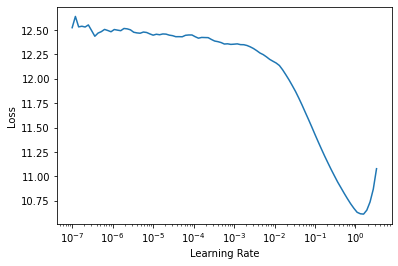

In [31]:
learn_lm.lr_find()

In [34]:
learn_lm.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.168715,3.853229,0.596982,0.403018,47.145050,30:22


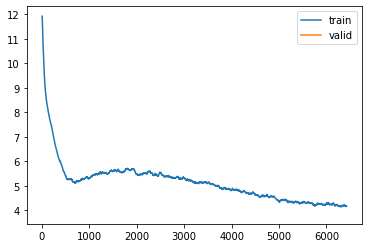

In [35]:
learn_lm.recorder.plot_loss()

In [36]:
learn_lm.unfreeze()

In [37]:
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 72 x 1152',   1,852,416  True      
________________________________________________________________
LSTM                 ['64 x 72 x 1152',   5,317,632  True      
________________________________________________________________
LSTM                 ['64 x 72 x 400', "  1,846,400  True      
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 30104      12,071,704 True      
_________________________________________________________

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=6.309573450380412e-07)

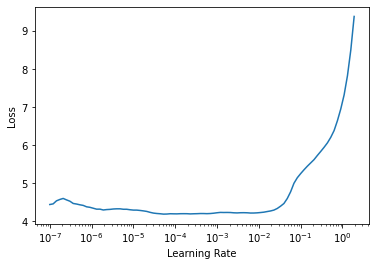

In [38]:
learn_lm.lr_find()

In [39]:
learn_lm.add_cbs([SaveModelCallback(monitor='accuracy', fname='best_fwd_lm'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.270921,3.087737,0.489450,0.510549,21.927406,33:25
1,2.711434,2.526734,0.395525,0.604475,12.512568,33:23
2,2.437684,2.334839,0.366017,0.633982,10.327798,33:22
3,2.455663,2.231624,0.350101,0.649899,9.314984,33:06
4,2.305157,2.181956,0.342432,0.657567,8.863625,33:28
5,2.296479,2.170962,0.340522,0.659479,8.766714,33:33


Better model found at epoch 0 with accuracy value: 0.5105494856834412.


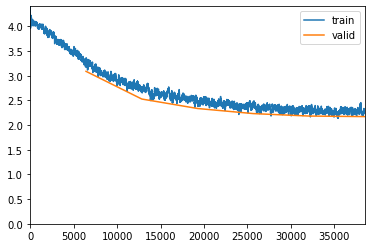

Better model found at epoch 1 with accuracy value: 0.6044745445251465.
Better model found at epoch 2 with accuracy value: 0.6339820027351379.
Better model found at epoch 3 with accuracy value: 0.6498993039131165.
Better model found at epoch 4 with accuracy value: 0.6575672030448914.
Better model found at epoch 5 with accuracy value: 0.6594788432121277.


In [40]:
learn_lm.fit_one_cycle(6, 1e-3)

In [41]:
learn_lm.load('best_fwd_lm')

In [42]:
learn_lm.save_encoder('best_fwd_lm_enc')

In [43]:
TEXT = "O Ministro"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [44]:
print("\n".join(preds))

▁xxbos ▁o xxunk ▁ministro ▁joaquim ▁barbosa ▁pois ▁fica ▁claro ▁que "} ▁xxbos ▁{" ministério ▁fazenda ▁procuradoria ▁geral ▁fazenda ▁nacional ▁procuradoria ▁secciona l ▁fazenda ▁nacional ▁campina ▁grande ▁rua ▁cap ▁joão ▁alves ▁lira ▁bairro ▁prata ▁cep ▁campina ▁grande ▁tel ▁fax ▁xxup ▁artigo _40 ▁aos ▁servidores ▁titulares
▁xxbos ▁o xxunk ▁ministro ▁moreira ▁alves ▁turma ▁quanto ▁alegação ▁inconstituciona lidade ▁xxup ▁artigo _219 o ▁cpc ▁nos ▁recursos ▁extraordinários ▁interpostos ▁pelo ▁inss ▁contra ▁acórdão ▁primeira ▁turma ▁recursal ▁dos ▁juizados ▁especiais ▁federais ▁seção ▁judiciária ▁rio ▁grande ▁sul ▁que ▁reconheceu ▁como ▁especial ▁tempo ▁serviço ▁prestado ▁condições


In [ ]:
dls_lm_bwd = DataBlock(
    blocks=(TextBlock.from_df('body', tok=dls_lm.tok, is_lm=True, backwards=True)),
    get_x=ColReader('text'), splitter=ColSplitter()).dataloaders(data)

In [7]:
assert dls_lm.vocab == dls_lm_bwd.vocab

In [45]:
del(dls_lm)

In [ ]:
torch.save(dls_lm_bwd, "./data/dls_lm_bwd.pth")

In [6]:
dls_lm_bwd = torch.load("./data/dls_lm_bwd.pth")

In [10]:
dls_lm_bwd.show_batch()

,text,text_
0,"""} ▁código ▁seguinte ▁com ▁site ▁xxup ▁validada ▁ser ▁pode ▁certidão ▁esta ▁gerada ▁certidão ▁eletrônico ▁documento ▁inicial ▁processamento ▁coordenadoria ▁maio ▁de brasília ▁{"" ▁xxbos ""} ▁impõe ▁que ▁medida ▁pedido ▁procedência ▁discutida ▁verba ▁indenizatória ▁natureza ▁diante ▁logo ▁renda ▁imposto ▁cálculo ▁base ▁correlato ▁valor ▁dedução ▁direito ▁possuem ▁contribuintes ▁que ▁modo ▁patrimonial ▁acréscimo ▁configura ▁não ▁plano ▁déficit ▁razão ▁instituída ▁extraordinária ▁contribuição ▁título ▁social ▁seguridade ▁banrisul ▁fundação ▁pago ▁valor ▁perdida ▁foi ▁que ▁parcela ▁recomposição ▁mera ▁mas ▁matemática","▁código ▁seguinte ▁com ▁site ▁xxup ▁validada ▁ser ▁pode ▁certidão ▁esta ▁gerada ▁certidão ▁eletrônico ▁documento ▁inicial ▁processamento ▁coordenadoria ▁maio ▁de brasília ▁{"" ▁xxbos ""} ▁impõe ▁que ▁medida ▁pedido ▁procedência ▁discutida ▁verba ▁indenizatória ▁natureza ▁diante ▁logo ▁renda ▁imposto ▁cálculo ▁base ▁correlato ▁valor ▁dedução ▁direito ▁possuem ▁contribuintes ▁que ▁modo ▁patrimonial ▁acréscimo ▁configura ▁não ▁plano ▁déficit ▁razão ▁instituída ▁extraordinária ▁contribuição ▁título ▁social ▁seguridade ▁banrisul ▁fundação ▁pago ▁valor ▁perdida ▁foi ▁que ▁parcela ▁recomposição ▁mera ▁mas ▁matemática ▁reserva"
1,▁nos ▁trabalhadores ▁dos ▁habitual ▁ganho ▁constitui ▁mesma ▁que ▁natalina ▁gratificação ▁sobre ▁previdenciária ▁contribuição ▁incide ▁que ▁considerando ▁nosso ▁grifo mani ▁sor e ▁alexandr ▁convocado ▁juiz ▁relator ▁data ▁fonte ▁citação ▁teor ▁inteiro ▁região ▁federal ▁regional ▁tribunal ▁seção ▁julgador ▁orgão ▁decisão ▁data ▁uf ▁processo ▁cível ▁apelação ▁classe ▁procedente ▁parcialmente ▁autora ▁parte ▁apelação ▁pertence ▁sepúlveda ▁min ▁stf ▁condicional ▁judicial ▁título ▁sentença ▁torna _1060 ▁lei ▁xxup _11 ▁artigo ▁xxup ▁nos ▁disposto ▁aplicação ▁que ▁decidiu ▁stf ▁e ▁pois,▁trabalhadores ▁dos ▁habitual ▁ganho ▁constitui ▁mesma ▁que ▁natalina ▁gratificação ▁sobre ▁previdenciária ▁contribuição ▁incide ▁que ▁considerando ▁nosso ▁grifo mani ▁sor e ▁alexandr ▁convocado ▁juiz ▁relator ▁data ▁fonte ▁citação ▁teor ▁inteiro ▁região ▁federal ▁regional ▁tribunal ▁seção ▁julgador ▁orgão ▁decisão ▁data ▁uf ▁processo ▁cível ▁apelação ▁classe ▁procedente ▁parcialmente ▁autora ▁parte ▁apelação ▁pertence ▁sepúlveda ▁min ▁stf ▁condicional ▁judicial ▁título ▁sentença ▁torna _1060 ▁lei ▁xxup _11 ▁artigo ▁xxup ▁nos ▁disposto ▁aplicação ▁que ▁decidiu ▁stf ▁e ▁pois ▁sucumbência
2,▁disposições ▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁parte ▁reforma ▁súmula raschi ▁b cio ▁clé ▁federal ▁juiz ▁relator ▁silva ▁batista ▁adriano o ▁recd ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto ▁recte ▁aprendiz ▁aluno ▁serv ▁tempo ▁cômputo ▁averb ▁prestações ▁relativas ▁diversas ▁disposições ▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁mantém ▁súmula ecato ▁c ▁reina ilton ▁u ▁federal ▁juiz ▁relator ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto o ▁recd ▁barroso,▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁parte ▁reforma ▁súmula raschi ▁b cio ▁clé ▁federal ▁juiz ▁relator ▁silva ▁batista ▁adriano o ▁recd ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto ▁recte ▁aprendiz ▁aluno ▁serv ▁tempo ▁cômputo ▁averb ▁prestações ▁relativas ▁diversas ▁disposições ▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁mantém ▁súmula ecato ▁c ▁reina ilton ▁u ▁federal ▁juiz ▁relator ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto o ▁recd ▁barroso a
3,"▁decisão ▁que ▁admitir ▁implicará ▁jurisdicional ▁exame ▁trazido ▁jurídico ▁argumento ▁sólido ▁como ▁acolher ▁instância ▁última ▁de ▁recorrida ▁decisão ▁conseqüência ▁processo ▁neste ▁exame ▁trazido ▁dico ▁jurí ▁argumento ▁acolhido ▁examinado ▁tenha ▁que ▁judiciária ▁seção ▁seja ▁que ▁qualquer ▁federais ▁especiais ▁juizados ▁dos ▁recursal ▁turma ▁mento ▁pronuncia ▁não ▁conhecer ▁autora ▁parte ▁dado ▁onde ▁até ▁associados ▁advogados ▁silva ▁ivo o anild ▁{"" ▁xxbos ""} ▁nacional ▁fazenda ▁procurador ▁s

In [7]:
learn_lm = language_model_learner(dls_lm_bwd, AWD_LSTM, path=Path("."), drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [8]:
learn_lm.freeze()
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 72 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 72 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 72 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 30104      12,071,704 True      
_________________________________________________________

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=0.0831763744354248)

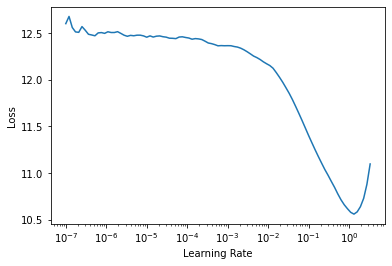

In [9]:
learn_lm.lr_find()

In [10]:
learn_lm.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.192403,3.836115,0.588019,0.411982,46.345058,32:45


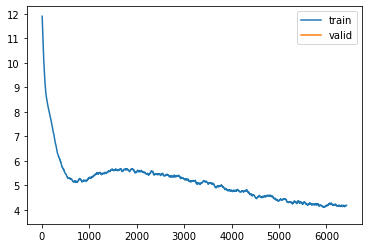

In [11]:
learn_lm.recorder.plot_loss()

In [12]:
learn_lm.unfreeze()

In [13]:
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 72 x 1152',   1,852,416  True      
________________________________________________________________
LSTM                 ['64 x 72 x 1152',   5,317,632  True      
________________________________________________________________
LSTM                 ['64 x 72 x 400', "  1,846,400  True      
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 30104      12,071,704 True      
_________________________________________________________

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=2.75422871709452e-06)

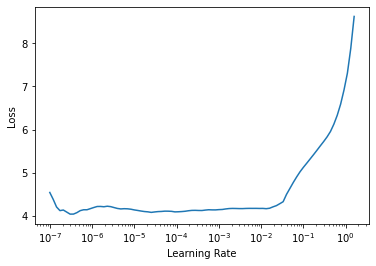

In [14]:
learn_lm.lr_find()

In [15]:
learn_lm.add_cbs([SaveModelCallback(monitor='accuracy', fname='best_bwd_lm'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.354810,3.075690,0.482987,0.517013,21.664831,35:42
1,2.861224,2.526672,0.391740,0.608259,12.511799,35:42
2,2.468735,2.333856,0.361802,0.638199,10.317654,35:21
3,2.389498,2.232136,0.346123,0.653877,9.319750,35:20
4,2.318906,2.180497,0.338911,0.661089,8.850701,35:37
5,2.271982,2.170482,0.337112,0.662888,8.762508,35:28


Better model found at epoch 0 with accuracy value: 0.5170133709907532.


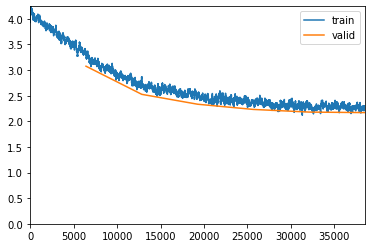

Better model found at epoch 1 with accuracy value: 0.6082594394683838.
Better model found at epoch 2 with accuracy value: 0.6381988525390625.
Better model found at epoch 3 with accuracy value: 0.6538771390914917.
Better model found at epoch 4 with accuracy value: 0.6610891222953796.
Better model found at epoch 5 with accuracy value: 0.6628881096839905.


In [16]:
learn_lm.fit_one_cycle(6, 1e-3)

In [17]:
learn_lm.load('best_bwd_lm')

In [18]:
learn_lm.save_encoder('best_bwd_lm_enc')

In [9]:
dls = DataBlock(
    blocks=(TextBlock.from_df('body', tok=dls_lm_bwd.tok),  CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('document_type'), splitter=ColSplitter()).dataloaders(data)

/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
assert dls.vocab[0] == dls_lm_bwd.vocab

In [19]:
del(dls_lm_bwd)

In [12]:
torch.save(dls, "./data/dls.pth")

In [20]:
dls = torch.load("./data/dls.pth")

In [11]:
n_samples = len(dls.train_ds); n_samples

149217

In [12]:
class_counts = torch.bincount(torch.stack(list(dls.train_ds.tls[1][:])))

In [13]:
class_weights = n_samples / (dls.c * class_counts); class_weights

TensorCategory([44.9720,  9.7681, 71.8772,  0.1854,  2.6154, 11.6813])

In [14]:
class_weights = torch.FloatTensor(class_weights).cuda(); class_weights

tensor([44.9720,  9.7681, 71.8772,  0.1854,  2.6154, 11.6813], device='cuda:0')

In [33]:
learn = text_classifier_learner(dls, AWD_LSTM, path=Path("."), drop_mult=1., 
                                loss_func=CrossEntropyLossFlat(weight=class_weights),
                                metrics=[accuracy, f1])

In [34]:
learn.load_encoder("lstm_lm_1E+3E+3E_enc")

In [35]:
learn.freeze()
learn.summary()

SequentialRNN (Input shape: ['64 x 4867'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 43 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 43 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 43 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 43 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
BatchNorm1d          64 x 1200            2,400      True      
_______________________________________________________

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=2.2908675418875646e-06)

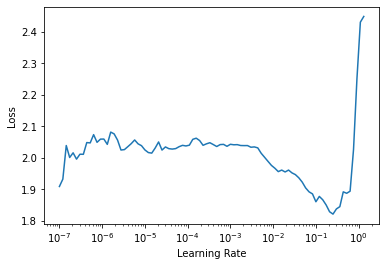

In [37]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.961801,0.864121,0.610271,0.298024,07:35


In [39]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.695018,0.644269,0.688901,0.368934,12:21


In [40]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.498383,0.598076,0.711680,0.404785,18:18


In [41]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.435686,0.570500,0.758579,0.449526,19:18
1,0.484861,0.559896,0.765198,0.440880,12:41


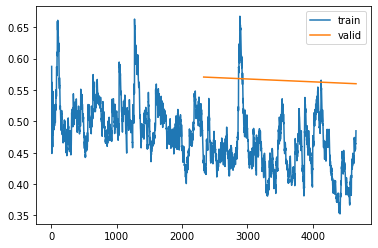

In [42]:
learn.recorder.plot_loss()

In [43]:
learn.save('fwd_clf')

Path('models/fwd_clf.pth')

In [ ]:
learn.load("fwd_clf")

In [6]:
dls = torch.load("./data/dls.pth")

In [32]:
learn = text_classifier_learner(dls, AWD_LSTM, path=Path("."), drop_mult=1., 
                                metrics=[accuracy, f1])

In [33]:
learn.load_encoder("best_fwd_lm_enc")

In [34]:
learn.freeze()
learn.summary()

SequentialRNN (Input shape: ['64 x 4867'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 43 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 43 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 43 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 43 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
BatchNorm1d          64 x 1200            2,400      True      
_______________________________________________________

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.6309573650360107)

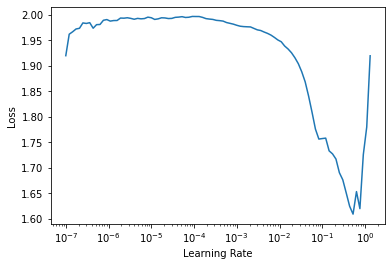

In [24]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.405888,0.295487,0.908418,0.441084,06:12


In [36]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.222479,0.227281,0.930860,0.633716,07:08


In [37]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.199173,0.210108,0.934016,0.672270,10:00


In [38]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fwd_clf'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.189204,0.207142,0.934945,0.682620,12:27
1,0.162333,0.203493,0.936085,0.689912,12:24
2,0.181387,0.198084,0.937995,0.690802,12:24
3,0.171051,0.191302,0.938745,0.702958,12:26
4,0.154034,0.188457,0.941088,0.714812,12:26
5,0.153357,0.186032,0.942049,0.725950,12:25
6,0.163162,0.196169,0.941447,0.715721,12:25
7,0.129408,0.187750,0.943474,0.726888,12:25
8,0.142808,0.191936,0.942176,0.715036,12:27
9,0.135923,0.192593,0.943843,0.731923,12:25


Better model found at epoch 0 with f1_score value: 0.6826198747184914.


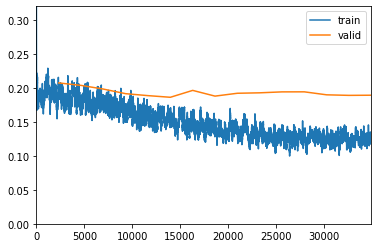

Better model found at epoch 1 with f1_score value: 0.6899118480831605.
Better model found at epoch 2 with f1_score value: 0.6908016106393647.
Better model found at epoch 3 with f1_score value: 0.7029576672102927.
Better model found at epoch 4 with f1_score value: 0.714812031854834.
Better model found at epoch 5 with f1_score value: 0.7259495763348452.
Better model found at epoch 7 with f1_score value: 0.7268882051028526.
Better model found at epoch 9 with f1_score value: 0.7319228862843409.
Better model found at epoch 10 with f1_score value: 0.739403882326242.
Better model found at epoch 11 with f1_score value: 0.7402877529711525.
Better model found at epoch 12 with f1_score value: 0.7458750187765687.
Better model found at epoch 13 with f1_score value: 0.7476837351650293.


In [39]:
learn.unfreeze()
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3))

In [ ]:
dls_bwd = DataBlock(
    blocks=(TextBlock.from_df('body', tok=dls.tok, backwards=True),  CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('document_type'), splitter=ColSplitter()).dataloaders(data)

In [ ]:
assert dls.vocab[0] == dls_bwd.vocab[0]

In [40]:
del(dls)

In [18]:
torch.save(dls_bwd, "./data/dls_bwd.pth")

In [41]:
dls_bwd = torch.load("./data/dls_bwd.pth")

In [42]:
learn = text_classifier_learner(dls_bwd, AWD_LSTM, path=Path("."), drop_mult=1., 
                                metrics=[accuracy, f1])

In [43]:
learn.load_encoder("best_bwd_lm_enc")

In [44]:
learn.freeze()
learn.summary()

SequentialRNN (Input shape: ['64 x 4867'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 43 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 43 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 43 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 43 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
BatchNorm1d          64 x 1200            2,400      True      
_______________________________________________________

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0691830962896347)

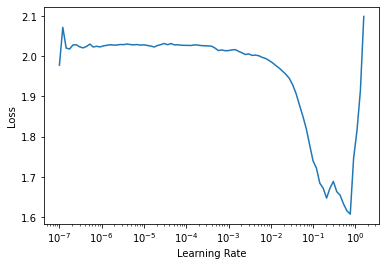

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.393218,0.309562,0.905399,0.403396,09:54


In [47]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.231894,0.238411,0.929646,0.625445,10:39


In [48]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.201917,0.215348,0.932865,0.660921,11:27


In [49]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_bwd_clf'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.188711,0.213327,0.934734,0.676217,12:35
1,0.194679,0.222338,0.934238,0.661876,12:36
2,0.186446,0.206793,0.938755,0.704440,12:33
3,0.167717,0.196710,0.940487,0.693081,12:32
4,0.165327,0.197576,0.941088,0.695771,12:32
5,0.156682,0.192896,0.942651,0.706700,12:33
6,0.149122,0.204121,0.941416,0.702907,12:31
7,0.134556,0.193896,0.942714,0.719654,12:27
8,0.127048,0.194037,0.944456,0.735753,12:28
9,0.143782,0.192365,0.942724,0.721261,12:31


Better model found at epoch 0 with f1_score value: 0.6762172591903233.


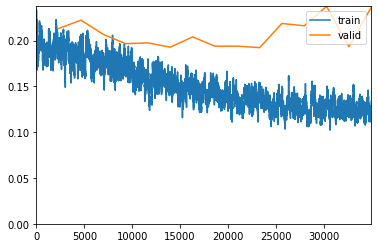

Better model found at epoch 2 with f1_score value: 0.704440032409153.
Better model found at epoch 5 with f1_score value: 0.7066998633113876.
Better model found at epoch 7 with f1_score value: 0.7196541812669176.
Better model found at epoch 8 with f1_score value: 0.7357533346411144.


In [50]:
learn.unfreeze()
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3))

In [29]:
learn = text_classifier_learner(dls_bwd, AWD_LSTM, path=Path("."), drop_mult=1., 
                                loss_func=CrossEntropyLossFlat(weight=class_weights),
                                metrics=[accuracy, f1])

In [30]:
learn.load_encoder("lstm_lm_1E+3E+3E_enc_bwd")

In [31]:
learn.freeze()
learn.summary()

SequentialRNN (Input shape: ['64 x 4867'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 43 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 43 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 43 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 43 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
BatchNorm1d          64 x 1200            2,400      True      
_______________________________________________________

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=7.585775847473997e-07)

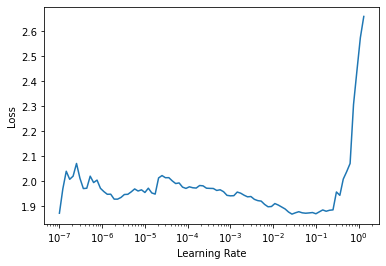

In [32]:
learn.lr_find()

In [33]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.076835,0.873939,0.610820,0.300344,06:10


In [34]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.633418,0.688326,0.649570,0.347064,07:11


In [35]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.557222,0.628877,0.698253,0.392610,10:05


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.458864,0.582287,0.751000,0.434046,12:26


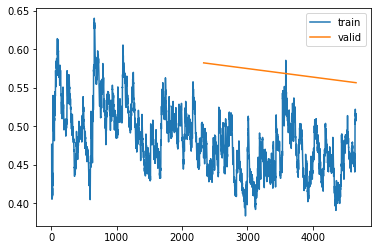

In [38]:
learn.recorder.plot_loss()

### Evaluate

In [8]:
dls = torch.load("./data/dls.pth")

In [8]:
test_csv["is_valid"]=True

In [9]:
test_items = tokenize_df(test_csv, "body", tok=dls.tok)

/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
test_dl = dls.test_dl(test_items[0], with_labels=True)

In [11]:
assert test_dl.vocab  == dls.vocab

In [9]:
learn_fwd = text_classifier_learner(dls, AWD_LSTM, path=Path("."), drop_mult=1., 
                                    metrics=[accuracy, f1])

In [12]:
learn_fwd.load("best_fwd_clf")

In [16]:
evaluate(learn_fwd, test_dl)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.7203    0.9341    0.8134       273
agravo_em_recurso_extraordinario     0.6623    0.4677    0.5482      1841
     despacho_de_admissibilidade     0.6914    0.6111    0.6488       198
                          outros     0.9637    0.9796    0.9716     85408
                   peticao_do_RE     0.8056    0.7068    0.7530      6331
                        sentenca     0.8312    0.7512    0.7892      1475

                        accuracy                         0.9472     95526
                       macro avg     0.7791    0.7417    0.7540     95526
                    weighted avg     0.9441    0.9472    0.9450     95526



In [10]:
dls_bwd = torch.load("./data/dls_bwd.pth")

In [18]:
test_dl_bwd = dls_bwd.test_dl(test_items[0], with_labels=True)

In [19]:
assert test_dl_bwd.vocab  == dls_bwd.vocab; del(dls_bwd)

In [ ]:
test_dl_bwd.show_batch()

In [11]:
learn_bwd = text_classifier_learner(dls, AWD_LSTM, path=Path("."), drop_mult=1., 
                                    metrics=[accuracy, f1])

In [13]:
learn_bwd.load("best_bwd_clf")

In [23]:
evaluate(learn_bwd, test_dl_bwd)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.8255    0.9011    0.8616       273
agravo_em_recurso_extraordinario     0.6467    0.4155    0.5060      1841
     despacho_de_admissibilidade     0.6359    0.5909    0.6126       198
                          outros     0.9602    0.9838    0.9718     85408
                   peticao_do_RE     0.8348    0.6632    0.7392      6331
                        sentenca     0.8200    0.7349    0.7751      1475

                        accuracy                         0.9467     95526
                       macro avg     0.7872    0.7149    0.7444     95526
                    weighted avg     0.9426    0.9467    0.9433     95526



In [24]:
evaluate_ensemble(learn_fwd, learn_bwd, test_dl, test_dl_bwd)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.8039    0.9158    0.8562       273
agravo_em_recurso_extraordinario     0.6628    0.4622    0.5446      1841
     despacho_de_admissibilidade     0.6882    0.5909    0.6359       198
                          outros     0.9621    0.9828    0.9723     85408
                   peticao_do_RE     0.8352    0.6852    0.7528      6331
                        sentenca     0.8405    0.7539    0.7949      1475

                        accuracy                         0.9485     95526
                       macro avg     0.7988    0.7318    0.7594     95526
                    weighted avg     0.9450    0.9485    0.9458     95526



In [14]:
evaluate_ensemble(learn_fwd, learn_bwd, dls.valid, dls_bwd.valid)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.7836    0.7993    0.7914       299
agravo_em_recurso_extraordinario     0.6817    0.4374    0.5329      2149
     despacho_de_admissibilidade     0.6821    0.6448    0.6629       183
                          outros     0.9607    0.9816    0.9711     84104
                   peticao_do_RE     0.8366    0.7355    0.7828      6364
                        sentenca     0.8498    0.6987    0.7669      1636

                        accuracy                         0.9467     94735
                       macro avg     0.7991    0.7162    0.7513     94735
                    weighted avg     0.9430    0.9467    0.9438     94735

